# Geomagnetic Models (eoxmagmod + contours)

> Authors: Ashley Smith, Martin Pačes
>
> Abstract: Demonstrate basic usage of eoxmagmod for forwards evaluation of magnetic model, together with contour visualisations with cartopy.

[eoxmagmod](https://github.com/ESA-VirES/MagneticModel/) is used internally within VirES to perform the forward evaluations of geomagnetic models. This notebook is a demonstration of using it directly for the simple .shc file case, though it can also be used to evaluate the more complex models. There is not much documentation but we could work to improve this (and the installation and usability) if it is useful.

Here we show a basic setup of contour plots using cartopy. It would be good to build a richer set of preset visualisations as part of an importable library.

See also:

 - https://github.com/pacesm/jupyter_notebooks/blob/master/examples/CHAOS-6_Cartopy_Contours.ipynb
 - https://github.com/MagneticEarth/MagneticEarth_notebooks

In [1]:
import os
os.environ['CDF_LIB'] = '/srv/conda/envs/notebook/lib'

%load_ext watermark
%watermark -i -v -p viresclient,pandas,xarray,matplotlib,scipy,cartopy,eoxmagmod,chaosmagpy

2020-03-12T14:54:34+00:00

CPython 3.7.6
IPython 7.11.1

viresclient 0.6.0
pandas 0.25.3
xarray 0.15.0
matplotlib 3.1.2
scipy 1.4.1
cartopy 0.17.0
eoxmagmod 0.9.7
chaosmagpy 0.2.1


In [2]:

import datetime as dt
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import eoxmagmod
from chaosmagpy.plot_utils import nio_colormap

## Functions to do the legwork of evaluation and plotting

In [3]:
def grid(nlats=180, nlons=360):
    """A global grid of the specified size"""
    _lats = np.linspace(-90, 90, nlats + 1)
    _lons = np.linspace(-180, 180, nlons + 1)
    coords = np.empty((_lats.size, _lons.size, 3))
    coords[:,:,1], coords[:,:,0] = np.meshgrid(_lons, _lats)
    coords[:,:,2] = 0 # height above WGS84 in km
    return coords

def eval_model(time=dt.datetime(2020, 1, 1), coords=grid(),
               shc_model=eoxmagmod.data.CHAOS_CORE_LATEST):
    """Evaluate a .shc model at a fixed time

    Args:
        time (datetime)
        coords (ndarray)
        shc_model (str): path to file

    Returns:
        dict: magnetic field vector components:
            https://intermagnet.github.io/faq/10.geomagnetic-comp.html
    """
    # Convert Python datetime to MJD2000
    epoch = eoxmagmod.util.datetime_to_decimal_year(time)
    mjd2000 = eoxmagmod.decimal_year_to_mjd2000(epoch)
    # Load model
    model = eoxmagmod.load_model_shc(shc_model)
    # Evaluate in North, East, Up coordinates
    height = eoxmagmod.GEODETIC_ABOVE_WGS84
    b_neu = model.eval(mjd2000, coords, height, height)
    # Inclination (I), declination (D), intensity (F)
    inc, dec, F = eoxmagmod.vincdecnorm(b_neu)
    return {"X": b_neu[:,:,0], "Y": b_neu[:,:,1], "Z": -b_neu[:,:,2],
            "I": inc, "D":dec, "F":F}

def _plot_contours(ax, x, y, z, *args, **kwargs):
    transform_before_plotting = kwargs.pop("transform_before_plotting", False)
    if transform_before_plotting:
        # transform coordinates *before* passing them to the plotting function
        tmp = ax.projection.transform_points(ccrs.PlateCarree(), x, y)
        x_t, y_t = tmp[..., 0], tmp[..., 1]
        return ax.contour(x_t, y_t, z, *args, **kwargs)
    else:
        # ... transformation performed by the plotting function creates glitches at the antemeridian
        kwargs["transform"] = ccrs.PlateCarree()
        return ax.contour(x, y, z, *args, **kwargs)

def plot_contours(ax, x, y, z, *args, **kwargs):
    fmt = kwargs.pop("fmt", "%g")
    fontsize = kwargs.pop("fontsize", 6)
    ax.add_feature(cfeature.LAND, facecolor=(1.0, 1.0, 0.9))
    ax.add_feature(cfeature.OCEAN, facecolor=(0.9, 1.0, 1.0))
    ax.add_feature(cfeature.COASTLINE, edgecolor='silver')
    ax.gridlines()
    cs = _plot_contours(ax, x, y, z, *args, **kwargs)
    ax.clabel(cs, cs.levels, inline=True, fmt=fmt, fontsize=fontsize)

def _apply_circular_boundary(ax):
    """Make cartopy axes have round borders.
    See https://scitools.org.uk/cartopy/docs/v0.15/examples/always_circular_stereo.html
    
    Notes:
        Inline contour labels are still appearing outside the boundary
    """
    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpl.path.Path(verts * radius + center)
    ax.set_boundary(circle, transform=ax.transAxes)

def contours_NorthSouthMoll(coords, data, units, title, **options):
    """Generate trio of AzimuthalEquidistant (N/S) and Mollweide projections
    
    Args:
        coords (ndarray)
        data (ndarray)
        units (str)
        title (str)
    """
    # Set up figure with North/South/Mollweide maps
    fig = plt.figure(figsize=(10, 10))
    fig.suptitle(title, fontsize=15)
    ax_N = plt.subplot2grid(
        (2, 2), (0, 0),
        projection=ccrs.AzimuthalEquidistant(
            central_longitude=0.0, central_latitude=90.0,
            false_easting=0.0, false_northing=0.0, globe=None
        )
    )
    ax_S = plt.subplot2grid(
        (2, 2), (0, 1), colspan=2,
        projection=ccrs.AzimuthalEquidistant(
            central_longitude=0.0, central_latitude=-90.0,
            false_easting=0.0, false_northing=0.0, globe=None
        )
    )
    ax_Moll = plt.subplot2grid(
        (2, 2), (1, 0), colspan=2,
        projection=ccrs.Mollweide()
    )
    ax_N.set_extent([-180, 180, 40, 90], ccrs.PlateCarree())
    ax_S.set_extent([-180, 180, -90, -40], ccrs.PlateCarree())
#     _apply_circular_boundary(ax_N)
#     _apply_circular_boundary(ax_S)
    # Plot on the contours from the given data
    # Set options and update with any overrides provided
    kwargs = {
        "fmt": f"%g {units}",
        "linewidths": 2,
        "fontsize": 10
    }
    kwargs.update(options)
    ## Masks to select the northern and southern parts separately
    # Notes:
    #  - the polar orthographic projection works only with all points
    #    within the maps extent (i.e., visible part of the globe).
    north = (coords[:, 0, 0] > 0).nonzero()[0]
    south = (coords[:, 0, 0] < 0).nonzero()[0]
    # Northern and Southern Hemipshere plots
    plot_contours(ax_N,
                  coords[north, :, 1], coords[north, :, 0], data[north, :],
                  transform_before_plotting=True, **kwargs)
    plot_contours(ax_S,
                  coords[south, :, 1], coords[south, :, 0], data[south, :],
                  transform_before_plotting=True, **kwargs)
    # Mollweide plot
    plot_contours(ax_Moll,
                  coords[..., 1], coords[..., 0], data,
                  transform_before_plotting=False, **kwargs)
#     fig.tight_layout()
    fig.subplots_adjust(hspace=0.05, wspace=0.05)
    return fig, [ax_N, ax_S, ax_Moll]

## Perform the model evaluation

In [4]:
t = dt.datetime(2020, 1, 1)
# You can supply your own shc file here
#  Just set shc_model as the file path
shc_model = eoxmagmod.data.CHAOS_CORE_LATEST
coords = grid()
mag_components = eval_model(t, coords, shc_model)
mag_components.keys()

dict_keys(['X', 'Y', 'Z', 'I', 'D', 'F'])

The evaluated model vector components are stored as a dictionary, `mag_components`, so that you can access the `X` (Northwards) component as `mag_components['X']` and so on, together with the matching coordinates stored in `coords`.

X: Northward, Y: Eastward, Z: Downward, I: Inclination, D: Declination, F: intensity

## Generate plots

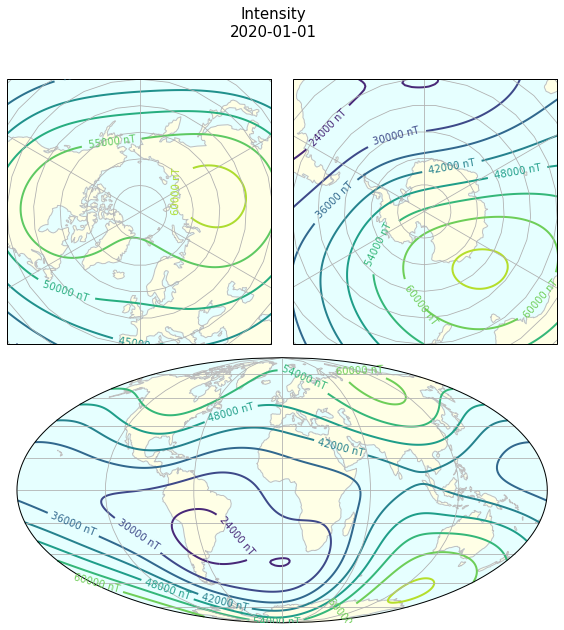

In [5]:
contours_NorthSouthMoll(
    coords, mag_components["F"], "nT",
    f"Intensity\n{t.date()}");

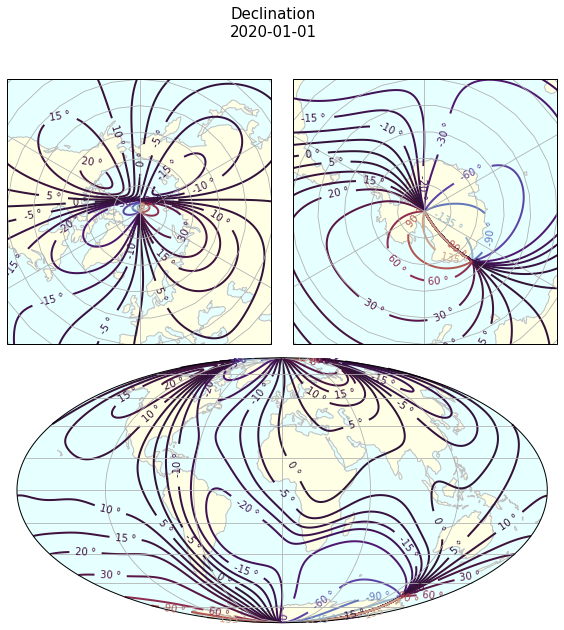

In [6]:
# Options can be fed through to the underlying matplotlib calls
options = {
    "levels": [-180, -135, -90, -60, -30, -20, -15, -10, -5, 0, 5, 10, 15, 20, 30, 60, 90, 135, 180],
    "cmap": "twilight"
}
contours_NorthSouthMoll(
    coords, mag_components["D"], "°",
    f"Declination\n{t.date()}", **options);

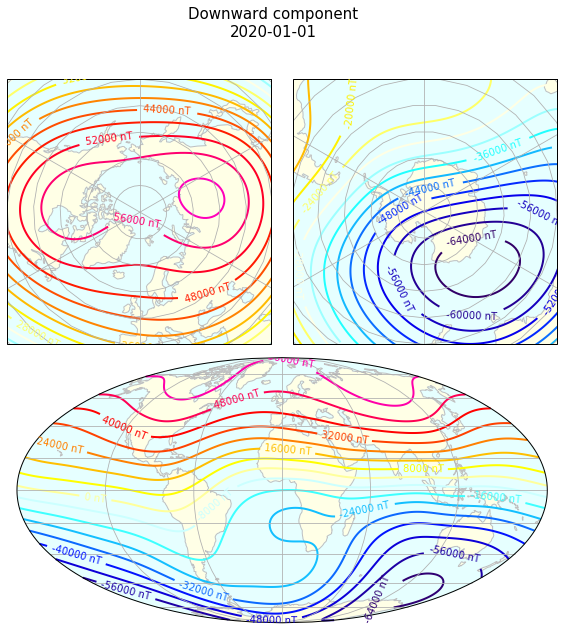

In [7]:
contours_NorthSouthMoll(
    coords, mag_components["Z"], "nT",
    f"Downward component\n{t.date()}",
    levels=20, cmap=nio_colormap());